In [376]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np 

In [377]:
df = pd.read_csv("cardio_train.csv", delimiter=";").drop("id", axis=1)
df.shape

(70000, 12)

In [378]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.4 MB


In [379]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


# Filter outliers in ap_hi & ap_lo (blood pressure)

In [380]:
df.shape

(70000, 12)

### a) Hur många är positiva för häart-kärlsjukdom och hur många är negativa?

In [381]:
# pos_cardio = df[df["cardio"] == 1]
# neg_cardio = df[df["cardio"] == 0]


# print(f"{len(pos_cardio) = }, {len(neg_cardio) = }")

df["cardio"].value_counts()

cardio
0    35021
1    34979
Name: count, dtype: int64

### b) Hur stor andel har normala, över normala och långt över normala kolesterolvärden?


In [382]:
# norm_cholest = len(df[df["cholesterol"] == 1])
# above_cholest = len(df[df["cholesterol"] == 2])
# well_cholest = len(df[df["cholesterol"] == 3])
# cholest = [norm_cholest, above_cholest, well_cholest]
# norm = ["Normal", "Above normal", "Well above normal"]

# for i, count in enumerate(cholest):
#     proportion = count/len(df)
#     print(f"{norm[i]}: num = {count}, proportion =  {proportion:.2f}, ---------- {proportion:.2%}")
    
chol_list = df["cholesterol"].value_counts()
type(chol_list) # pandas.core.series.Series

for i in range(1, 4):
    print(f"Andel: {i}. {chol_list[i]/len(df):.1%}")
chol_list[2]

Andel: 1. 74.8%
Andel: 2. 13.6%
Andel: 3. 11.5%


9549

###  c) Hur ser åldersfördelningen ut?

In [383]:
df_age = (df["age"]/365).round(1)

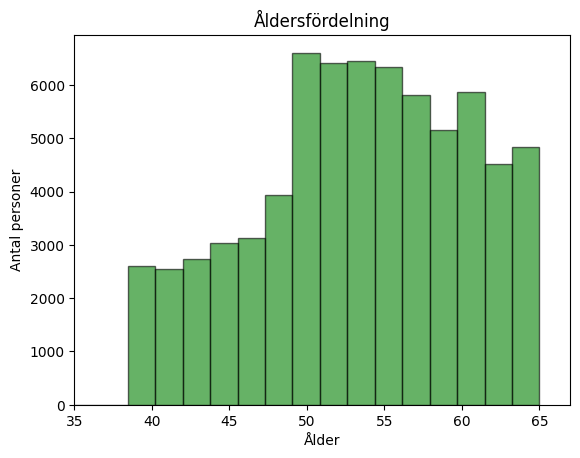

In [384]:
plt.hist(df_age, bins=20, color='green', edgecolor='black', alpha=0.6)
plt.xlim(35, 67)

plt.title('Åldersfördelning')
plt.xlabel('Ålder')
plt.ylabel('Antal personer')
plt.show()

### d) Hur stor andel röker?

In [385]:
smokers = df[df["smoke"] == 1]
smoke_prop = len(smokers) / len(df)

print(f"{smoke_prop = :.2%}")

smoke_prop = 8.81%


### e) Hur ser viktfördelningen ut?


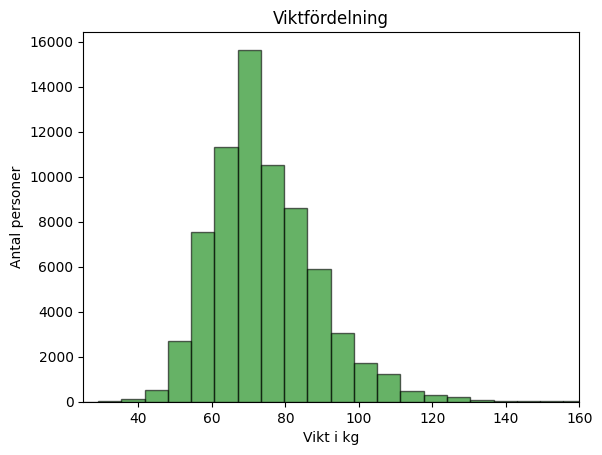

In [386]:
plt.hist(df["weight"], bins=30, color='green', edgecolor='black', alpha=0.6)
plt.xlim(25, 160)

plt.title('Viktfördelning')
plt.xlabel('Vikt i kg')
plt.ylabel('Antal personer')
plt.show()

### f) Hur ser längdfördelningen ut?

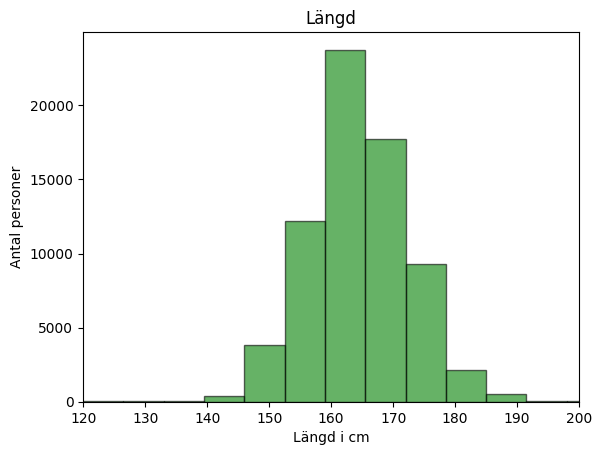

In [387]:
plt.hist(df["height"], bins=30, color='green', edgecolor='black', alpha=0.6)
plt.xlim(120, 200)

plt.title('Längd')
plt.xlabel('Längd i cm')
plt.ylabel('Antal personer')
plt.show()

### g) Hur stor andel av kvinnor respektive män har hjärt-kärlsjukdom?

In [388]:
women = df[df["gender"] == 1]
men = df[df["gender"] == 2]

num_women_cardio = len(women[women["cardio"] == 1])
num_men_cardio = len(men[men["cardio"] == 1])

print(f"{num_women_cardio = } | {num_men_cardio = }")

print(f"{num_women_cardio/len(df) = :.2%} | {num_men_cardio/len(df) = :.2%}")

num_women_cardio = 22616 | num_men_cardio = 12363
num_women_cardio/len(df) = 32.31% | num_men_cardio/len(df) = 17.66%


# !!!!!!!!!!!!!! Sammanfatta dina resultat och presentera dem i en notebook. Anv¨and markdown boxar f¨or l¨opande text.

# 1.2 Modelldesign

In [389]:
df.corr()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
age,1.000000,-0.022811,-0.081515,0.053684,0.020764,0.017647,0.154424,0.098703,-0.047633,-0.029723,-0.009927,0.238159
gender,-0.022811,1.000000,0.499033,0.155406,0.006005,0.015254,-0.035821,-0.020491,0.338135,0.170966,0.005866,0.008109
height,-0.081515,0.499033,1.000000,0.290968,0.005488,0.006150,-0.050226,-0.018595,0.187989,0.094419,-0.006570,-0.010821
weight,0.053684,0.155406,0.290968,1.000000,0.030702,0.043710,0.141768,0.106857,0.067780,0.067113,-0.016867,0.181660
ap_hi,0.020764,0.006005,0.005488,0.030702,1.000000,0.016086,0.023778,0.011841,-0.000922,0.001408,-0.000033,0.054475
ap_lo,0.017647,0.015254,0.006150,0.043710,0.016086,1.000000,0.024019,0.010806,0.005186,0.010601,0.004780,0.065719
cholesterol,0.154424,-0.035821,-0.050226,0.141768,0.023778,0.024019,1.000000,0.451578,0.010354,0.035760,0.009911,0.221147
gluc,0.098703,-0.020491,-0.018595,0.106857,0.011841,0.010806,0.451578,1.000000,-0.004756,0.011246,-0.006770,0.089307
smoke,-0.047633,0.338135,0.187989,0.067780,-0.000922,0.005186,0.010354,-0.004756,1.000000,0.340094,0.025858,-0.015486
alco,-0.029723,0.170966,0.094419,0.067113,0.001408,0.010601,0.035760,0.011246,0.340094,1.000000,0.025476,-0.007330


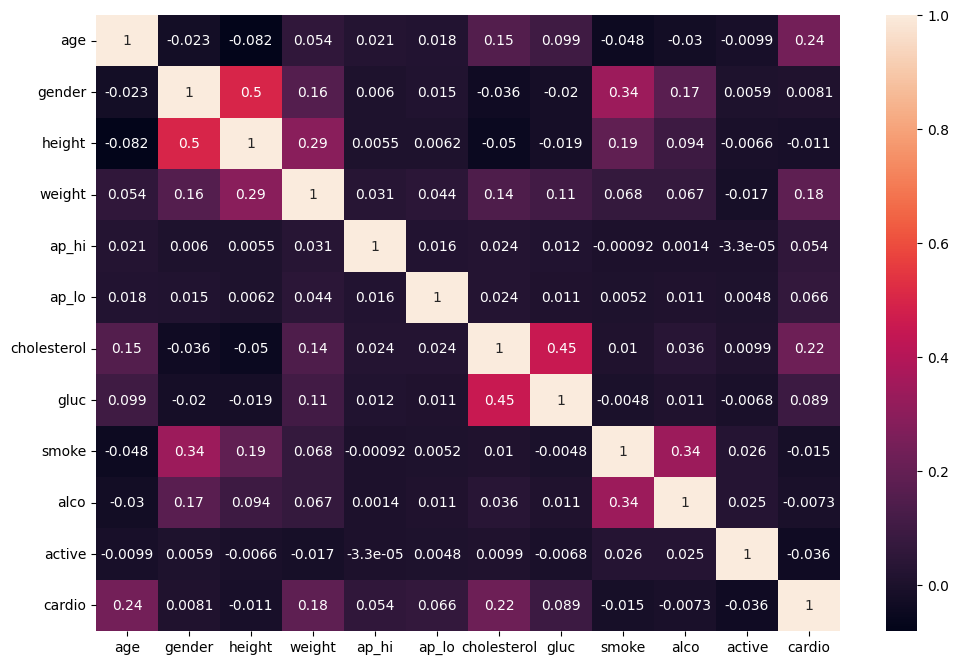

In [390]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True)
plt.show()

# 1.2.1 Feature Engineering

$$BMI = \frac{kg}{m^2}$$


In [391]:
bmi_data = {
    'Category': [
        'Underweight (Severe thinness)',
        'Underweight (Moderate thinness)',
        'Underweight (Mild thinness)',
        'Normal range',
        'Overweight (Pre-obese)',
        'Obese (Class I)',
        'Obese (Class II)',
        'Obese (Class III)'
    ],
    'BMI (kg/m2)[c]': [
        '< 16.0',
        '16.0 – 16.9',
        '17.0 – 18.4',
        '18.5 – 24.9',
        '25.0 – 29.9',
        '30.0 – 34.9',
        '35.0 – 39.9',
        '≥ 40.0'
    ]
}

tabell_bmi = pd.DataFrame(bmi_data)
tabell_bmi

,Category,BMI (kg/m2)[c]
0,Underweight (Severe thinness),< 16.0
1,Underweight (Moderate thinness),16.0 – 16.9
2,Underweight (Mild thinness),17.0 – 18.4
3,Normal range,18.5 – 24.9
4,Overweight (Pre-obese),25.0 – 29.9
5,Obese (Class I),30.0 – 34.9
6,Obese (Class II),35.0 – 39.9
7,Obese (Class III),≥ 40.0


In [392]:
df["BMI"] = df["weight"] / (df["height"]/100)**2
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23.011177


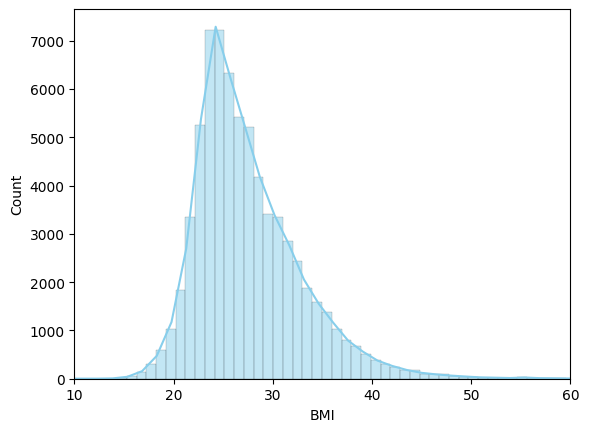

In [393]:
sns.histplot(df["BMI"], kde=True, bins=300, color='skyblue')
plt.xlim(10, 60)

plt.show()

In [394]:
df.shape

(70000, 13)

### a) Sl¨ang de samples med orimliga BMIer och outliers. Notera att detta kanvara sv˚art att avg¨ora i vilket range av BMIer som vi ska spara. Beskriv hur du kommer fram till gr¨anserna, med resonemang eller referens.

In [395]:
df["BMI"].min(), df["BMI"].max()

(3.471783865673526, 298.6666666666667)

In [396]:
filter_bmi = ((df["BMI"] > 15) & (df["BMI"] < 50)) 
df = df[filter_bmi]
df["BMI"].min(), df["BMI"].max(), df.shape

(15.012197410395949, 49.99999999999999, (69729, 13))

In [397]:
tabell_bmi

,Category,BMI (kg/m2)[c]
0,Underweight (Severe thinness),< 16.0
1,Underweight (Moderate thinness),16.0 – 16.9
2,Underweight (Mild thinness),17.0 – 18.4
3,Normal range,18.5 – 24.9
4,Overweight (Pre-obese),25.0 – 29.9
5,Obese (Class I),30.0 – 34.9
6,Obese (Class II),35.0 – 39.9
7,Obese (Class III),≥ 40.0


### b) Skapa en kategorisk BMI-feature med kategorierna: normal range, overweight, obese (class I), obese (class II), obese (class III).

In [398]:
df["class_BMI"] = np.where((df["BMI"] >= 18.5) & (df["BMI"] < 25), "normal range",
                           np.where((df["BMI"] >= 25) & (df["BMI"] < 30), "overweight",
                                    np.where((df["BMI"] >= 30) & (df["BMI"] < 35), "obese_1",
                                             np.where((df["BMI"] >= 35) & (df["BMI"] < 40), "obese_2",
                                                      np.where(df["BMI"] >= 40, "obese_3", None)
                                                     )
                                            )
                                   )
                          )

In [399]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,class_BMI
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,normal range
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,obese_1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,normal range
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,overweight
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,normal range


In [400]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69729 entries, 0 to 69999
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          69729 non-null  int64  
 1   gender       69729 non-null  int64  
 2   height       69729 non-null  int64  
 3   weight       69729 non-null  float64
 4   ap_hi        69729 non-null  int64  
 5   ap_lo        69729 non-null  int64  
 6   cholesterol  69729 non-null  int64  
 7   gluc         69729 non-null  int64  
 8   smoke        69729 non-null  int64  
 9   alco         69729 non-null  int64  
 10  active       69729 non-null  int64  
 11  cardio       69729 non-null  int64  
 12  BMI          69729 non-null  float64
 13  class_BMI    69106 non-null  object 
dtypes: float64(2), int64(11), object(1)
memory usage: 8.0+ MB


In [401]:
df.dropna(inplace=True)
len(df)

69106

### c) Unders¨ok om kategorin ¨ar relevant, dvs dess korrelationer. Uppdatera data-analysen om du hittar n˚agot intressant.

In [402]:
df_encoded = pd.get_dummies(df, columns = ["class_BMI"], dtype=int)
df_encoded.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,class_BMI_normal range,class_BMI_obese_1,class_BMI_obese_2,class_BMI_obese_3,class_BMI_overweight
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,1,0,0,0,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,0,1,0,0,0
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,1,0,0,0,0
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,0,0,0,0,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,1,0,0,0,0


In [403]:
df_encoded.corr()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,class_BMI_normal range,class_BMI_obese_1,class_BMI_obese_2,class_BMI_obese_3,class_BMI_overweight
age,1.000000,-0.023090,-0.086649,0.050780,0.020330,0.017272,0.153978,0.098998,-0.047793,-0.029648,-0.009572,0.236905,0.101285,-0.089651,0.055368,0.045959,0.020726,0.016411
gender,-0.023090,1.000000,0.522407,0.164986,0.006138,0.015649,-0.035368,-0.019940,0.338494,0.170459,0.005956,0.008222,-0.114295,0.040826,-0.048181,-0.076170,-0.073505,0.059013
height,-0.086649,0.522407,1.000000,0.329603,0.005693,0.006378,-0.054661,-0.020175,0.196484,0.098155,-0.008171,-0.011198,-0.197437,0.111614,-0.093345,-0.115528,-0.100496,0.052122
weight,0.050780,0.164986,0.329603,1.000000,0.029957,0.042702,0.141207,0.103282,0.073427,0.069513,-0.016601,0.178847,0.855913,-0.619732,0.368996,0.408094,0.401635,-0.003261
ap_hi,0.020330,0.006138,0.005693,0.029957,1.000000,0.015915,0.023603,0.011632,-0.000878,0.001384,-0.000071,0.054063,0.028458,-0.020472,0.011664,0.011165,0.016989,0.000302
ap_lo,0.017272,0.015649,0.006378,0.042702,0.015915,1.000000,0.023818,0.010643,0.005532,0.010804,0.004536,0.064979,0.040958,-0.029452,0.013810,0.023530,0.022514,-0.000379
cholesterol,0.153978,-0.035368,-0.054661,0.141207,0.023603,0.023818,1.000000,0.450431,0.010618,0.036096,0.009621,0.220907,0.174691,-0.130268,0.095452,0.090064,0.063671,-0.010471
gluc,0.098998,-0.019940,-0.020175,0.103282,0.011632,0.010643,0.450431,1.000000,-0.004346,0.011517,-0.006976,0.088080,0.117033,-0.081839,0.066789,0.055944,0.046762,-0.013810
smoke,-0.047793,0.338494,0.196484,0.073427,-0.000878,0.005532,0.010618,-0.004346,1.000000,0.340260,0.025432,-0.015236,-0.031205,-0.000226,-0.010973,-0.021011,-0.018959,0.025578
alco,-0.029648,0.170459,0.098155,0.069513,0.001384,0.010804,0.036096,0.011517,0.340260,1.000000,0.025546,-0.007012,0.018009,-0.028541,0.013889,0.003538,0.001941,0.015282


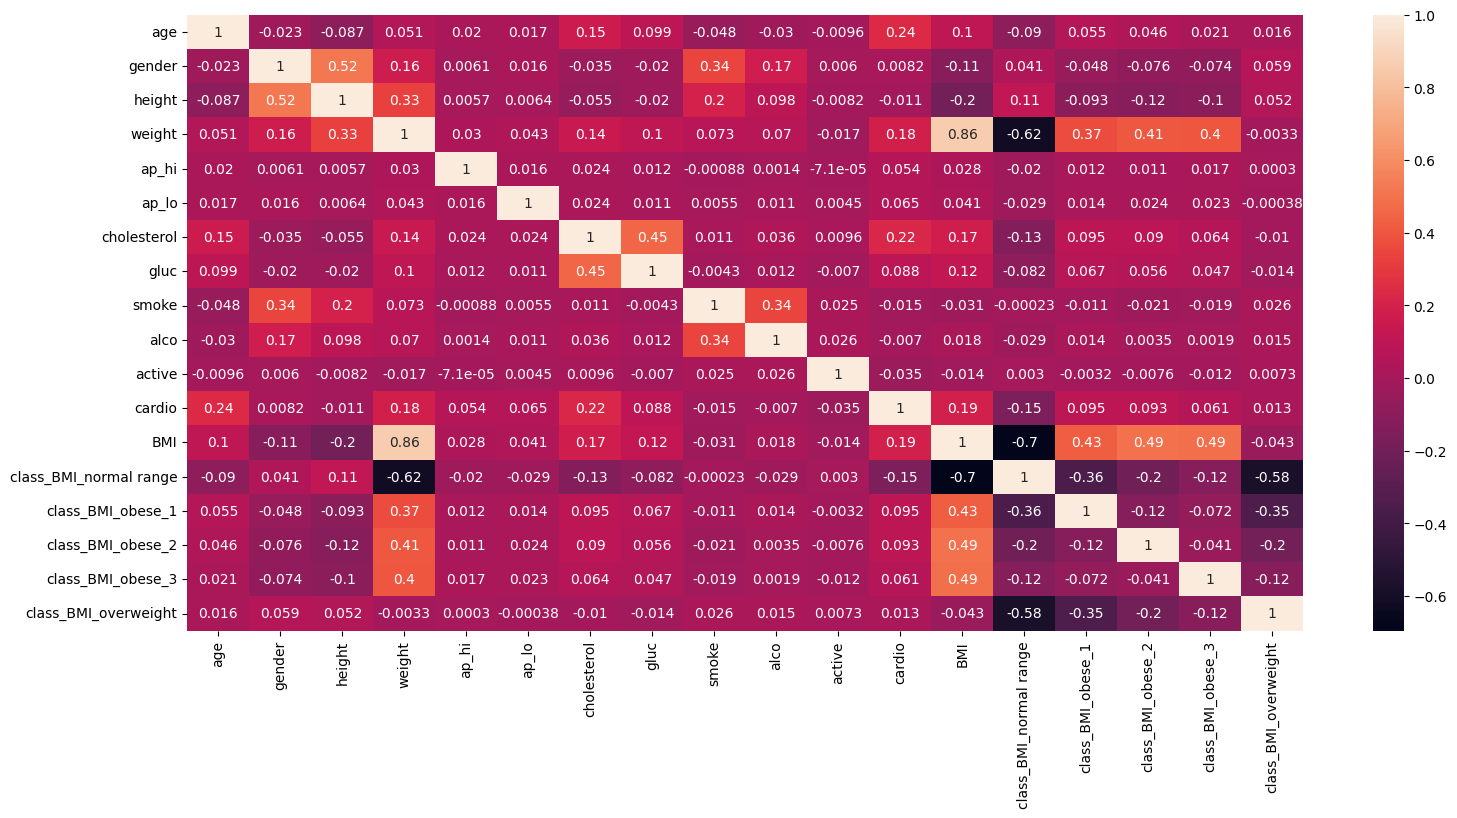

In [404]:
plt.figure(figsize=(18, 8))
sns.heatmap(df_encoded.corr(), annot=True)
plt.show()

#### c) Unders¨ok om kategorin ¨ar relevant, dvs dess korrelationer. Uppdatera data-analysen om du hittar n˚agot intressant.

BMI påverkar Cardio med 0.19, kan vara  nåt intressant ???????

### Skapa en feature f¨or blodtryckskategorier enligt tabellen i denna artikel.
a) Sl¨ang bort samples med orimliga blodtryck och outliers. Likt f¨orra uppgiften ¨ar det inte trivialt att s¨atta gr¨anserna. Beskriv hur du kommer fram
till gr¨anserna. https://www.ncbi.nlm.nih.gov/books/NBK570233/table/ch1.tab1/

In [405]:
print(df.shape)

(69106, 14)


In [406]:
filter_outliers_ap = ((df["ap_hi"] > 70) & (df["ap_hi"] < 200) & (df["ap_lo"] > 40) & (df["ap_lo"] < 150))
df = df[filter_outliers_ap]

df.reset_index(drop=True, inplace=True)
df.shape

(67701, 14)

In [407]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,class_BMI
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,normal range
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,obese_1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,normal range
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,overweight
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,normal range


### b) Skapa en kategorisk feature med relevanta kategorier. https://www.ncbi.nlm.nih.gov/books/NBK570233/table/ch1.tab1/
https://en.wikipedia.org/wiki/Blood_pressure

In [458]:
df["class_ap"] = np.where((df["ap_hi"] < 90) & (df["ap_lo"] < 60), "low_press",
                           np.where(((90 <= df["ap_hi"]) & (df["ap_hi"] < 130)) & ((60 <= df["ap_lo"]) & (df["ap_lo"] <= 80)), "normal_press",
                                             np.where((df["ap_hi"] >= 130) | (df["ap_lo"] >= 90), "High_press", None)))


In [464]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,class_BMI,class_ap
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,normal range,normal_press
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,obese_1,High_press
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,normal range,High_press
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,overweight,High_press
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,normal range,normal_press


In [462]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67358 entries, 0 to 67700
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          67358 non-null  int64  
 1   gender       67358 non-null  int64  
 2   height       67358 non-null  int64  
 3   weight       67358 non-null  float64
 4   ap_hi        67358 non-null  int64  
 5   ap_lo        67358 non-null  int64  
 6   cholesterol  67358 non-null  int64  
 7   gluc         67358 non-null  int64  
 8   smoke        67358 non-null  int64  
 9   alco         67358 non-null  int64  
 10  active       67358 non-null  int64  
 11  cardio       67358 non-null  int64  
 12  BMI          67358 non-null  float64
 13  class_BMI    67358 non-null  object 
 14  class_ap     67358 non-null  object 
dtypes: float64(2), int64(11), object(2)
memory usage: 8.2+ MB


# c) Unders¨ok om den nya kategorin ¨ar relevant, dvs har den n˚agon nyttig korrelation? Uppdatera data-analysen om du hittar n˚agot intressant.
Tips: Efter du valt gr¨anser och skapat kategorier, kolla vilka kategorier som
faktiskt f¨orekommer i din data.


In [470]:
df_encoded = pd.get_dummies(df, columns = ["class_BMI", "class_ap"], dtype=int)


In [471]:
df_encoded

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,...,cardio,BMI,class_BMI_normal range,class_BMI_obese_1,class_BMI_obese_2,class_BMI_obese_3,class_BMI_overweight,class_ap_High_press,class_ap_low_press,class_ap_normal_press
0,18393,2,168,62.0,110,80,1,1,0,0,...,0,21.967120,1,0,0,0,0,0,0,1
1,20228,1,156,85.0,140,90,3,1,0,0,...,1,34.927679,0,1,0,0,0,1,0,0
2,18857,1,165,64.0,130,70,3,1,0,0,...,1,23.507805,1,0,0,0,0,1,0,0
3,17623,2,169,82.0,150,100,1,1,0,0,...,1,28.710479,0,0,0,0,1,1,0,0
4,17474,1,156,56.0,100,60,1,1,0,0,...,0,23.011177,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67696,21074,1,165,80.0,150,80,1,1,0,0,...,1,29.384757,0,0,0,0,1,1,0,0
67697,19240,2,168,76.0,120,80,1,1,1,0,...,0,26.927438,0,0,0,0,1,0,0,1
67698,19066,2,183,105.0,180,90,3,1,0,1,...,1,31.353579,0,1,0,0,0,1,0,0
67699,22431,1,163,72.0,135,80,1,2,0,0,...,1,27.099251,0,0,0,0,1,1,0,0


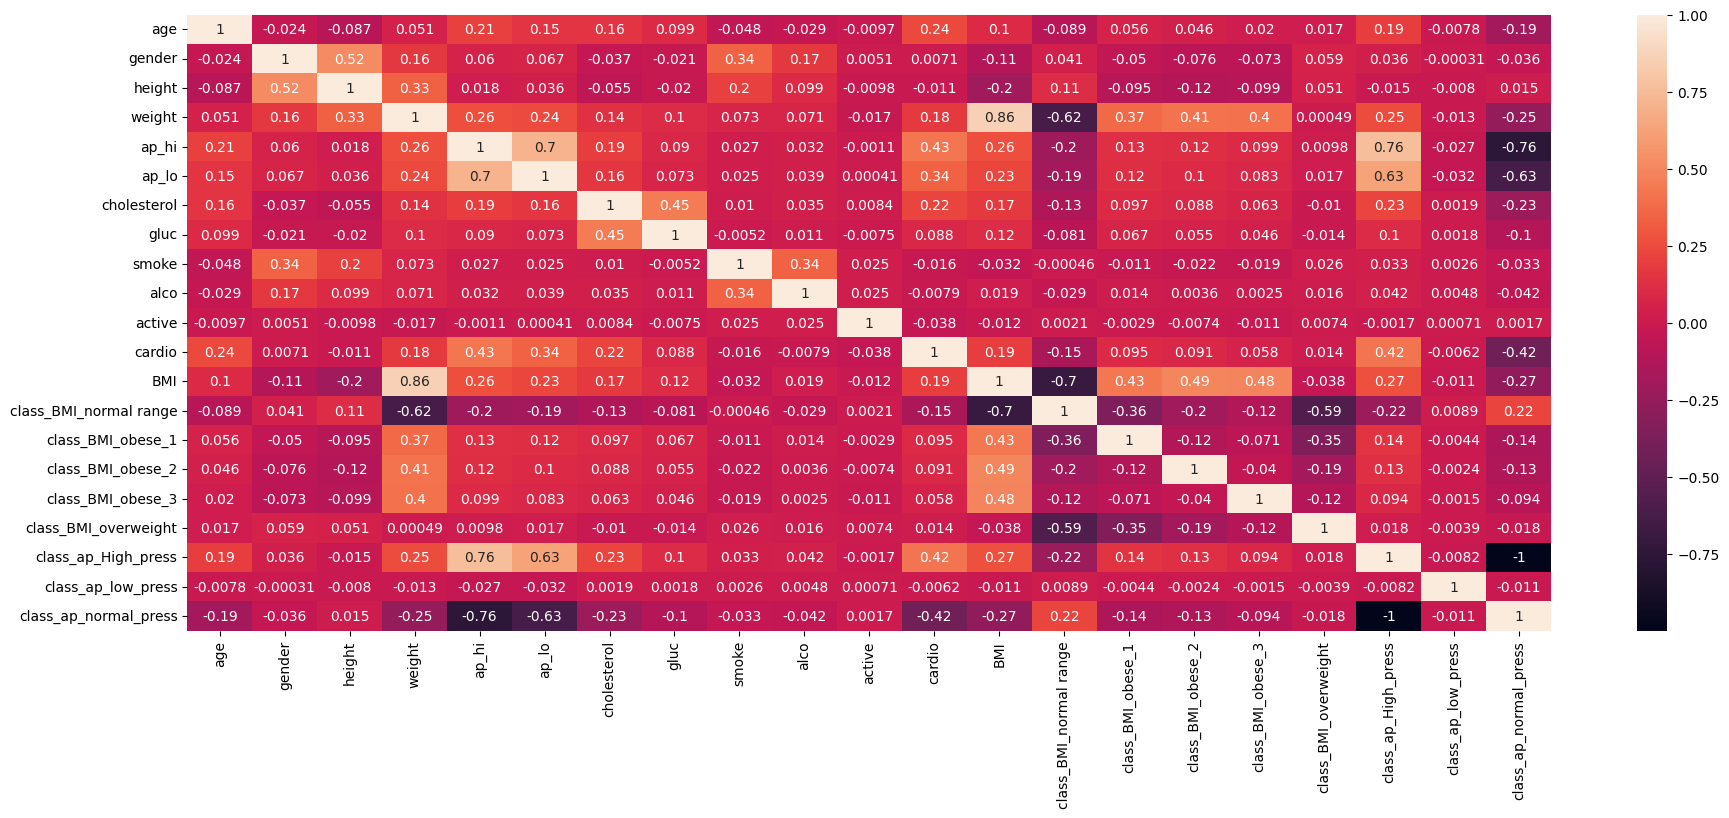

In [475]:
plt.figure(figsize=(22, 8))
sns.heatmap(df_encoded.corr(), annot=True)
plt.show()

###   ap_High på cardio ??????????????????????

# 1.2.2 Skapa tv˚a dataset
